--- Loaded Data (first 5 rows) ---
   wavelength    efficiency
0    0.931000  2.191901e-09
1    0.931135  1.828837e-09
2    0.931270  9.193326e-10
3    0.931405  4.997221e-10
4    0.931541  1.075342e-09

--- Data Types ---
wavelength    float64
efficiency    float64
dtype: object


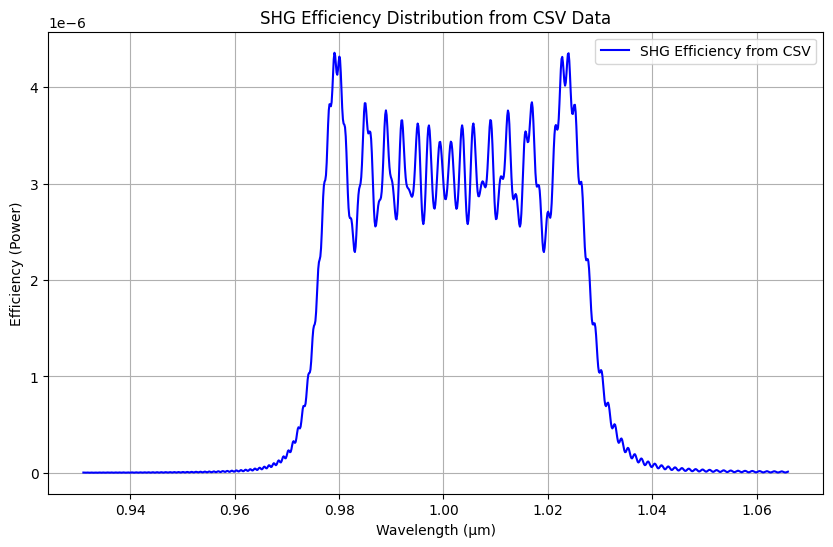

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np  # 必要に応じて数値計算用

# --- CSVファイルの読み込み ---
# CSVファイル名を指定（前のスクリプトで出力したファイル名）
csv_filename = 'chirped_shg_efficiency.csv'

# pandasを使ってCSVファイルを読み込む
# header=0 は1行目をヘッダーとして認識させるため（デフォルト）
# encoding='utf-8' は前のスクリプトで指定したエンコーディングに合わせる
df_data = pd.read_csv(csv_filename, header=0, encoding='utf-8')

# データの確認（最初の数行を表示）
print("--- Loaded Data (first 5 rows) ---")
print(df_data.head())
print("\n--- Data Types ---")
print(df_data.dtypes)  # 各列のデータ型を確認

# --- データの抽出 ---
# CSVファイルの列名に合わせてデータを抽出
wavelength_column_name = 'wavelength'
efficiency_column_name = 'efficiency'

if wavelength_column_name not in df_data.columns:
    raise ValueError(
        f"Error: Column '{wavelength_column_name}' not found in {csv_filename}")
if efficiency_column_name not in df_data.columns:
    raise ValueError(
        f"Error: Column '{efficiency_column_name}' not found in {csv_filename}")

wavelengths_loaded = df_data[wavelength_column_name].values
efficiency_loaded = df_data[efficiency_column_name].values

# --- Matplotlibでプロット ---
plt.figure(figsize=(10, 6))  # グラフのサイズを設定

# データをプロット
plt.plot(wavelengths_loaded, efficiency_loaded,  # type: ignore
         color='blue', label='SHG Efficiency from CSV')

# グラフの装飾
plt.xlabel("Wavelength (μm)")  # X軸ラベル
plt.ylabel("Efficiency (Power)")       # Y軸ラベル
plt.title("SHG Efficiency Distribution from CSV Data")  # グラフタイトル
plt.legend()      # 凡例を表示
plt.grid(True)    # グリッドを表示

# 必要に応じてY軸の範囲などを調整
# plt.ylim(0, max(efficiency_loaded) * 1.1) # 例: Y軸の最小値を0、最大値をデータの最大値の1.1倍に

# グラフを表示
plt.show()

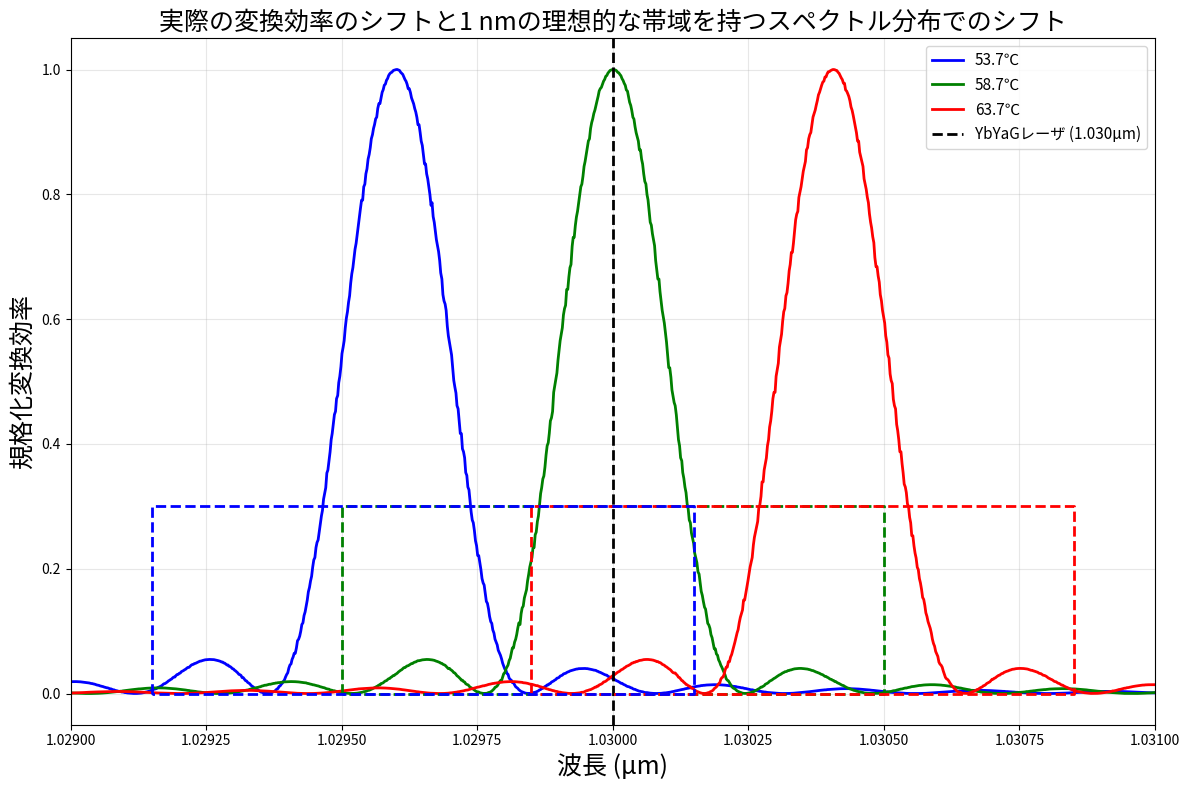

In [39]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from syuron import shg, mgoslt, pp

# パラメータ設定
WAVELENGTH_MIN = 1.029
WAVELENGTH_MAX = 1.031
WAVELENGTH_POINTS = 1000
YBYAG_WAVELENGTH = 1.030

# 固定グレーティングパラメータ
fixed_grating = pp.fixed(int(10000/3.6), [3.6], 1.031E-05)

# 波長範囲の設定
wavelengths = jnp.linspace(WAVELENGTH_MIN, WAVELENGTH_MAX, WAVELENGTH_POINTS).tolist()
delta_wavelength = wavelengths[1] - wavelengths[0]

best_temp = 58.7
# 温度設定（テンソルとして並列計算）
temperatures = [best_temp-5, best_temp, best_temp+5]

# 温度を全て含むテンソルで並列計算
params = shg.Params(
    grating_dim=fixed_grating,
    T_dim=temperatures,  # リスト全体を渡す
    wavelength_dim=wavelengths,
    fund_power_dim=1,
    sh_power_dim=0,
)

# 並列計算実行
eff_tensor = (jnp.abs(mgoslt.analyze(params))**2).squeeze()
# 各温度での最大値で規格化
eff_tensor = eff_tensor / jnp.max(eff_tensor, axis=1, keepdims=True)

plt.figure(figsize=(12, 8))

colors = ['blue', 'green', 'red', 'orange']
labels = [f'{t}℃' for t in temperatures]

# 結果をプロット（(4,1000)なので温度が第一次元）
for i, temp in enumerate(temperatures):
    plt.plot(wavelengths, eff_tensor[i, :],
             color=colors[i], linewidth=2, label=labels[i])

# YbYaGレーザの波長に垂直線を追加
plt.axvline(x=YBYAG_WAVELENGTH, color='black', linestyle='--', linewidth=2,
            label=f'YbYaGレーザ ({YBYAG_WAVELENGTH:.3f}µm)')

# 矩形を追加
rect_height = 0.3
rect_width = 0.001
middle_rect = 1.030
rect_center_positions = [middle_rect, middle_rect + 0.00035, middle_rect - 0.00035]
rect_colors = ['green', 'red', 'blue']

for i, (center, color) in enumerate(zip(rect_center_positions, rect_colors)):
    left = center - rect_width / 2
    right = center + rect_width / 2
    # 矩形の枠線のみ描画
    plt.plot([left, left, right, right, left], [0, rect_height, rect_height, 0, 0], 
             color=color, linewidth=2, linestyle='--')

plt.xlabel('波長 (µm)', fontsize=18)
plt.ylabel('規格化変換効率', fontsize=18)
plt.title('実際の変換効率のシフトと1 nmの理想的な帯域を持つスペクトル分布でのシフト', fontsize=18)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.xlim(WAVELENGTH_MIN, WAVELENGTH_MAX)

plt.tight_layout()
plt.show()

95%以上の効率を保持する温度範囲: 58.35°C - 59.05°C
温度帯域幅: 0.70°C


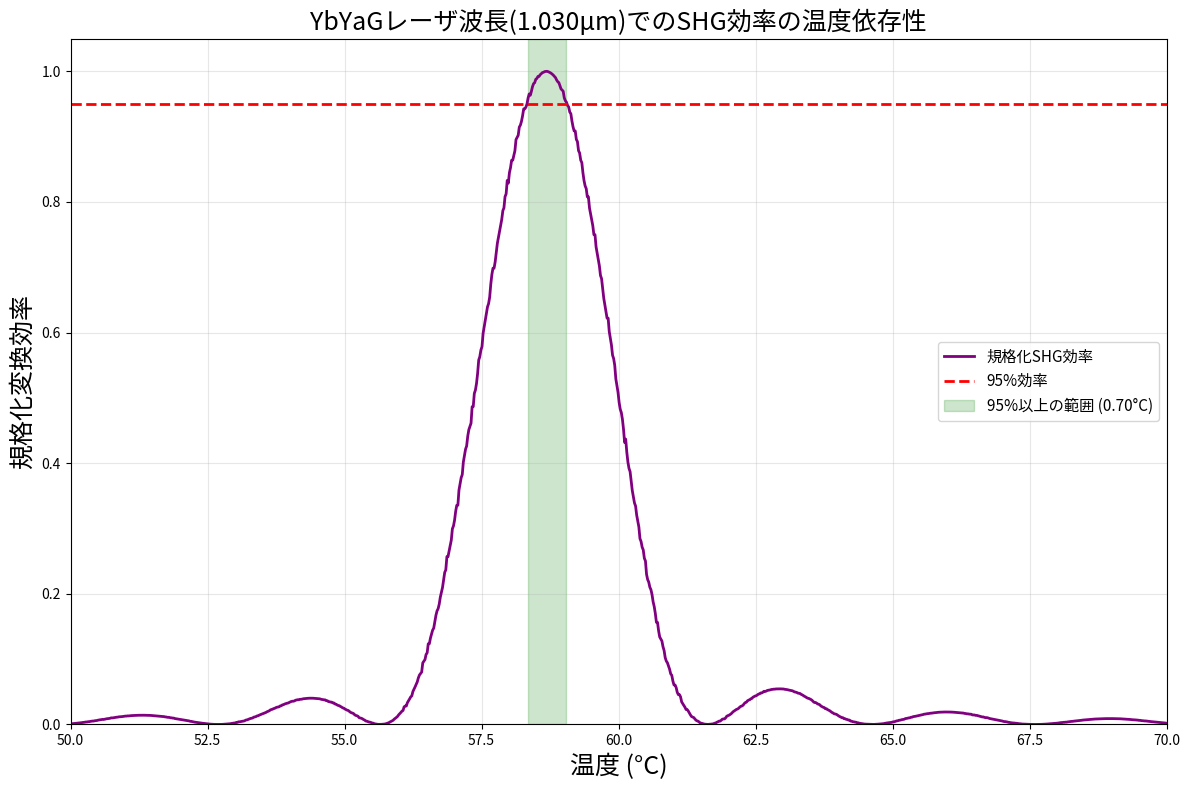

In [25]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from syuron import shg, mgoslt, pp

# パラメータ設定（YbYaG波長固定、温度依存性を調べる）
YBYAG_WAVELENGTH = 1.030
TEMP_MIN = 50
TEMP_MAX = 70
TEMP_POINTS = 1000

# 固定グレーティングパラメータ
fixed_grating = pp.fixed(int(10000/3.6), [3.6], 1.031E-05)

# 温度範囲の設定
temperatures = jnp.linspace(TEMP_MIN, TEMP_MAX, TEMP_POINTS).tolist()

# YbYaG波長を固定して温度依存性を計算
params = shg.Params(
    grating_dim=fixed_grating,
    T_dim=temperatures,  # 温度を配列として渡す
    wavelength_dim=[YBYAG_WAVELENGTH],  # 波長を固定
    fund_power_dim=1,
    sh_power_dim=0,
)

# 並列計算実行
eff_tensor = (jnp.abs(mgoslt.analyze(params))**2).squeeze()

# 最大値で規格化
eff_normalized = eff_tensor / jnp.max(eff_tensor)

# 95%以上の効率を保持する温度範囲を計算
threshold = 0.95
high_eff_indices = jnp.where(eff_normalized >= threshold)[0]

if len(high_eff_indices) > 0:
    temp_range_min = temperatures[high_eff_indices[0]]
    temp_range_max = temperatures[high_eff_indices[-1]]
    temp_bandwidth = temp_range_max - temp_range_min
    print(f"95%以上の効率を保持する温度範囲: {temp_range_min:.2f}°C - {temp_range_max:.2f}°C")
    print(f"温度帯域幅: {temp_bandwidth:.2f}°C")
else:
    print("95%以上の効率を保持する温度範囲が見つかりません")

plt.figure(figsize=(12, 8))

# 温度依存性をプロット
plt.plot(temperatures, eff_normalized, color='purple', linewidth=2, label='規格化SHG効率')

# 95%効率のラインを追加
plt.axhline(y=threshold, color='red', linestyle='--', linewidth=2, label='95%効率')

# 95%以上の範囲をハイライト
if len(high_eff_indices) > 0:
    plt.axvspan(temp_range_min, temp_range_max, alpha=0.2, color='green', 
                label=f'95%以上の範囲 ({temp_bandwidth:.2f}°C)')

plt.xlabel('温度 (°C)', fontsize=18)
plt.ylabel('規格化変換効率', fontsize=18)
plt.title(f'YbYaGレーザ波長({YBYAG_WAVELENGTH:.3f}µm)でのSHG効率の温度依存性', fontsize=18)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.xlim(TEMP_MIN, TEMP_MAX)
plt.ylim(0, 1.05)

plt.tight_layout()
plt.show()